# Automated Inference with PyMC


## Fit a posterior



* We will use PyMC to fit the model below to the data set provided.
* Check that the sampler is working correctly.
* Plot and interpret the posterior distribution.

**Given Model:**

$$p \sim \text{Beta}(\alpha=2,\beta=2)$$

$$x_i \sim \text{Negative-Binomial}(r=3,p) \quad i=1,\ldots,20$$

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import matplotlib.pyplot as plt
import arviz as az
import random
from IPython.display import Image

In [2]:
# Import PyMC 
print('Upgrading PyMC to version 5. This takes about 50 seconds...')
!pip install --ignore-installed llvmlite > /dev/null 2> /dev/null
!pip install --upgrade "pymc>=5,<6" numexpr matplotlib numba > /dev/null 2> /dev/null

import pymc as pm
print(f"We're running PyMC v{pm.__version__} today.")



Upgrading PyMC to version 5. This takes about 50 seconds...
We're running PyMC v5.10.3 today.


In [3]:
data = [9, 15, 4, 7, 7, 1, 3, 5, 8, 7, 9, 8, 4, 3, 0, 4, 6, 9, 2, 4]

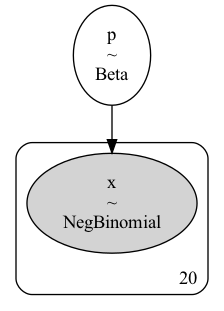

In [4]:
# Create a model matches the way we expect data to be generated in the real world.
data = [9, 15, 4, 7, 7, 1, 3, 5, 8, 7, 9, 8, 4, 3, 0, 4, 6, 9, 2, 4]
with pm.Model() as model:
    p = pm.Beta('p', alpha=2, beta=2)
    pm.NegativeBinomial(
        'x', n=data, p=p, observed=data)
Image(pm.model_to_graphviz(model).render(format='png'))

In [5]:
# Setting up the model using pm.Model(). Code is modified from CS146 Session 3
with pm.Model() as model:
    # Prior
    p = pm.Beta('p', alpha = 2, beta = 2)
    # Likelihood
    pm.NegativeBinomial('x', n = 3, p = p, observed = data)
    # Number of trials
    inference = pm.sample(2000)
inference

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 89 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [6]:
az.summary(inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.346,0.035,0.281,0.41,0.001,0.0,3089.0,5450.0,1.0


<Axes: title={'center': 'p'}, xlabel='Rank (all chains)', ylabel='Chain'>

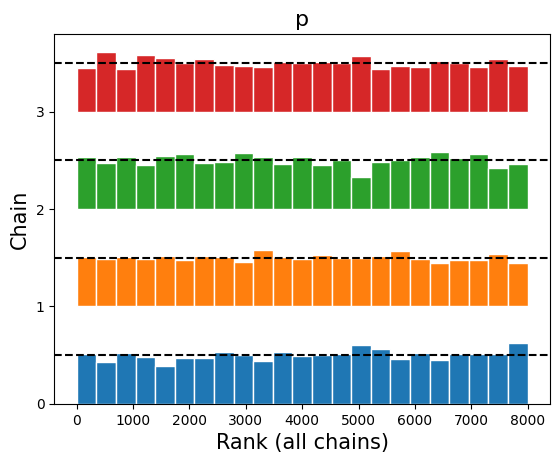

In [7]:
az.plot_rank(inference)

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

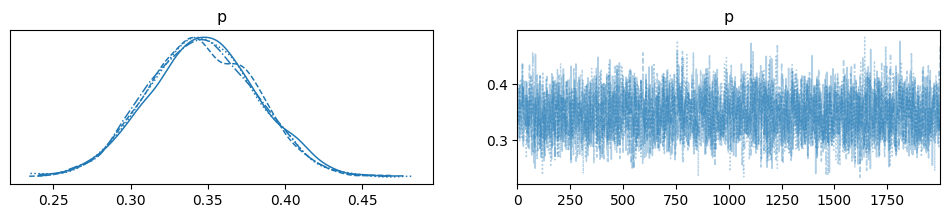

In [8]:
az.plot_trace(inference)

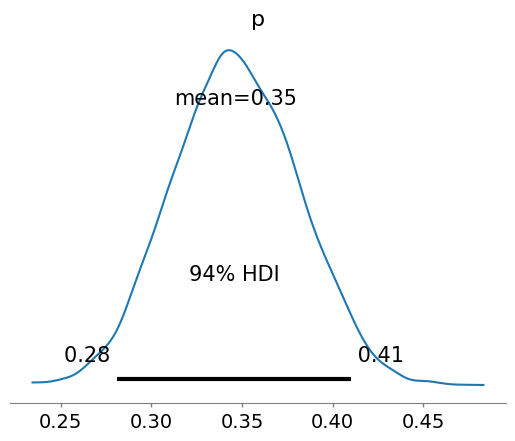

In [9]:
az.plot_posterior(inference, var_names=['p'])
plt.show()

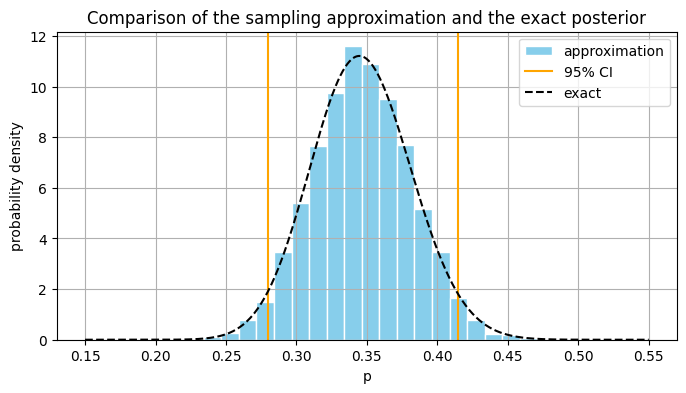

Analytical mean = 0.343
Sample mean = 0.346
95% Credible interval of the sample= [0.279 0.414]


In [10]:
# Code adopted and modified appropriately from CS146 Sessions 2 and 4
all_p_samples = inference.posterior.p.values.flatten()
# Hyperparameters of the prior 
alpha = 2
beta = 2
# Known parameter of the likelihood
r = 3 
# Visualize comparison between approximation and the exact posterior

# Plot the histogram of the sample distribution
plt.figure(figsize = (8, 4))
plt.title('Comparison of the sampling approximation and the exact posterior')
plt.xlabel('p')
plt.ylabel('probability density')
plt.hist(
    all_p_samples, bins = 20, density = True,
    edgecolor='white', color = 'skyblue', label='approximation')
# 95% credible interval
cred_interval = np.quantile(all_p_samples, [0.025, 0.975])
# Plot the 95% credible interval of the sample distribution
plt.axvline(x = cred_interval[0], color = 'orange',  label = '95% CI')
plt.axvline(x = cred_interval[1], color = 'orange')

# Exact posterior
x = np.linspace(0.15, 0.55, 500) # For better clarity
y = sts.beta.pdf(x, alpha+len(data)*r, beta+sum(data)) # Analytical Solution
plt.plot(x, y, label = 'exact', color = 'black', linestyle = '--')
plt.legend()
plt.grid(linestyle = 'solid')
plt.show()

# Exact mean from analytical solution
analytical_mean = len(data)*r / (len(data)*r + sum(data))


# Extract approximate posterior mean value from pm.summary table
summary = pm.summary(inference)
# Sample Mean
sample_mean = float(summary['mean'].values)

# Print the results
print(f'Analytical mean = {round(analytical_mean,3)}')
print(f'Sample mean = {sample_mean}')
print(f'95% Credible interval of the sample= {np.round(cred_interval,3)}')

### Exact and Sampled Posterior Discussion and Interpretation
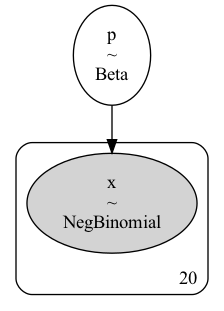
<t><center>Figure 1. Model.</center></t>

#### Prior
$$p \sim \text{Beta}(\alpha=2,\beta=2)$$
#### Likelihood
$$x_i \sim \text{Negative-Binomial}(r=3,p) \quad i=1,\ldots,20$$

The model/data story shows that the parameter $p$ follows beta distribution, and the likelihood function follows negative binomial distribution. Our prior distribution is beta with specified hyperparameters $\alpha = \beta = 2$. The likelihood function follows a negative binomial distribution with parameters $ r=3 $ and an unknown $p$. Negatve-binomial distribution is a probability distribution that describes the number of independent and identically distributed Bernoulli trials needed for a specified number of successes to occur. In the likelihood function, the unknown/unobserved variable is $p$, the probability of success. Meanwhile, the known/observed variable is $r$, a specified number of successes. Another piece of information is 20 data points, which were provided and will be used in the Bayesian process of updating our beliefs to find the value of unknown parameter $p$ (McElreath, 2020, p. 31). This value representing twenty data points is also displayed in figure 1 above. 
 
Given this information to find posterior distribution, we can use Bayes' formula to fit a posterior. 

<t><center>$f_{posterior}\propto f_{likelihood}\times f_{prior}$</center></t>
<t><center>$p(\theta|x)\propto p(x|\theta)\times p(\theta)$</center></t>

Given that the prior is a beta distribution the posterior distribution will also be a Beta distribution because of conjugacy. However, the $\alpha$ and $\beta$ values of the posterior distribution will be different.  
#### Posterior
$$(p|s,f) \sim \text{Beta}(\alpha,\beta)$$

Here $s$ represents success where $f$ represents failure. However, these values are unknown and can be approximated using a sampling process. Calculating $p$ will help us in this process, and then we can find expected success, $s$ = $p\times n$, and expected failure $f$ = $(1-p)\times n$. Where $n$ is the total number of trials. We will talk about finding exact $\alpha$ and $\beta$ values analytically below. 

We will use two approaches to fit the posterior. First, we will use PyMC and approximate the posterior using inference by sampling. To do this, the model was defined with the following known variables: prior distribution, its hyperparameters, and the likelihood function. Next, we ran the NUTS sampler and stored the results in the variable called inference. To check the results, we called $az.summary()$ to look at how the sampling process went. 

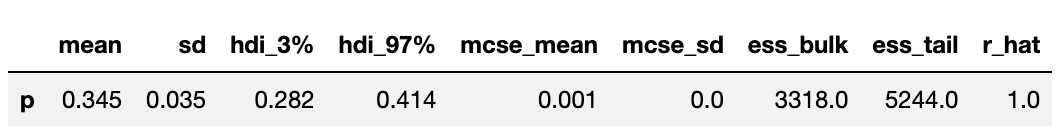
<t><center>Figure 2. Sampling Summary Statistics.</center></t>
Sampling summary statistics provide us with a quick glimpse of what happened in the chains of samples that were generated by the NUTS algorithm. It shows the information about the posterior distributions over all the model parameters and gives us statistics values that reflect the quality of the sampling process (CS146, 2024). Let's evaluate how the sampling process went. 
#### Overview of the Summary
1. $\hat{R}$ We wanted an r hat value to be very close to 1. We see from the summary table that $\hat{R}=1.0$, which is exactly what we wanted. Anything greater than 1.01 would not have been okay. $\hat{R}$ Rhat diagnostic is basically a comparison of within and between chain variances. If all chains are sampling the same distribution it will necessarily be close to 1 as within and between chain variances will be the same. Since our $\hat{R}=1.0$ This is the indicator that sampling has converged and works well. 
2. Next are two effective sample size (ESS) columns. The sampling algorithm is more accurate if these values are large: at least a few hundred. From the summary, we see that $ESS_{tail}$ and $ESS_{bulk}$ values are 3318.0 and 5244.0, respectively. The ESS measures how successful the sampling algorithm was in ensuring that consecutive samples are uncorrelated. As a rule of thumb, we want greater than 10% of our sampling size, which was set to 2000. We see that our values are quite large, which indicates that our model is successful and samples are random from all the chains. 
3. $MCSE_{mean}$ and $MCSE_{sd}$ show how much sampling error there is in the estimates in the mean and SD columns. Our errors are very low, indicating that there is a low correlation in a Markow chain.
4. $Mean$ is the sample mean of the parameter $p$. Our sample has approximated the expected value to be $p=0.345$. Meaning that the approximate probability of success is $p=0.345$ after using inference by sampling.
5. $SD$ is the sample standard deviation of the parameter. 
6. $hdi_{3\%}$ and $hdi_{97\%}$ are the left and right boundaries of the 94% highest density interval of the distribution. 

#### Rank Plots
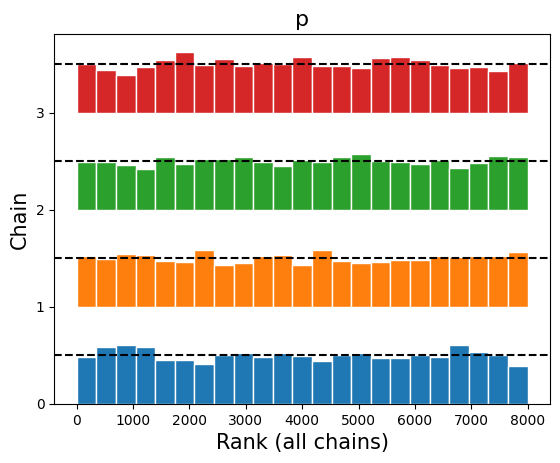
<t><center>Figure 3. Rank plots.</center></t>
To quickly tell if our sampler worked correctly, we can look at rank plots, which show us one histogram for each unobserved variable in the model and each chain in the sampler. I ran four chains. Thus, there are four histograms. We are looking to see if the sampler has explored the whole posterior distribution, and if we restarted the sampler from a different initial point, it should also explore the whole posterior distribution. If the sampler is working correctly, we will see a uniform distribution that lies close to the dashed black line. Looking at Figure 3, we observe that all of our four chains are approximately uniform, which means that our sampler explores the whole posterior distribution across all ranks and doesn't get stuck in a particular place of the distribution. 

#### Trace Plot
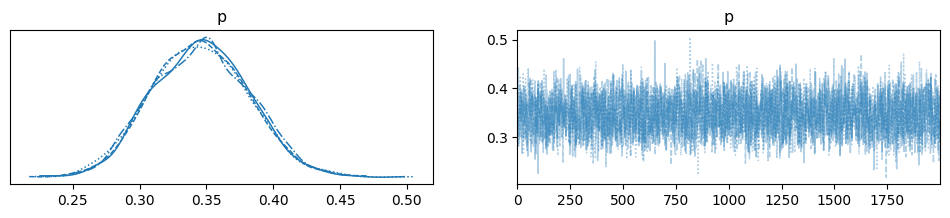
<t><center>Figure 4. Trace plot.</center></t>
The last thing that we will look at is trace plots that output two plots. On the left, we see all the sample distributions for $p$ value. It is clear from the graph that all four samples are converging and have similar shapes and peaks around $p\approx0.35.$ This is another indicator that the sampler is working correctly. On the right side, we see the trace plot that represents how each chain sample $p$ values out of 2000 trials. In this graph, we want a lot of fluctuation, which represents that different values of $p$ were sampled by each chain within each trail. This means that the sampler did not get stuck on one particular value of $p$, and it took steps in all directions.
$ \\ $

#### Summary
In summary, the posterior distribution indicates that the mean value of $p$ is approximately $p=0.345.$ The $95\%$ credible interval is $[0.28, 0.417]$  meaning that $95\%$ mass of all values lay within these two bounds. As a side note, McElreath 2020 uses compatibility intervals instead of credible intervals, and this definition might be more accurate and defines it as " a range of parameter values compatible with the model and data" (McElreath, 2020, p. 54). This definition steers away from words such as credibility and confidence since if the model is wrong, so are $95\%$ intervals, and one cannot be confident about them. However, in the context of this setup and data, I am positive that we can be confident about these intervals. We walked through how different diagnostics tests helpt us with ensuring that sampling procedure has been successful and that Markov Chains have converged. We reported $\hat{R}$ value, alongside with Effective Sample Sizes and other statistics that are relevant for evaluating sampling process. We display the results of the sampling approximation approach in the figure 6 below.

 

The second approach to fit the posterior is finding the posterior analytically. Since we only have twenty data points and are using beta distribution as a prior, it will be easy to use this approach and find the exact value of $p$. However, this approach is not always useful since it is hard to compute the exact posterior if the dataset is large or the prior is not a conjugate. 

After some research, it was found that given that the prior follows a beta distribution and that given a sample 
<t><center>$x=(x_1,....x_n)$</center></t> 
of negative-binomial data. The posterior distribution will be given by: 
<t><center>$p(\theta|x) \sim Beta(\alpha+rn,\beta+\sum_{i=1}^{n}x_i$)</center></t> 
Where n is the number of data points (Bernardo et al., 1994), in our case, n=20, and r is the number of successes, $r=3$. 
Thus, we have: 
<t><center>$p(\theta|x) \sim Beta(\alpha+3\cdot 20,\beta+\sum_{i=1}^{20}x_i$)</center></t> 
Using this formula and Python, the exact posterior can be easily computed analytically. This calculation is performed above using this code line: 

<t><center>$y = sts.beta.pdf(x, alpha+len(data)*r, beta+sum(data))$</center></t>

The resulting plot comparing the exact posterior and posterior obtained using sampling approximation was coded above and is also given in the figure below.  

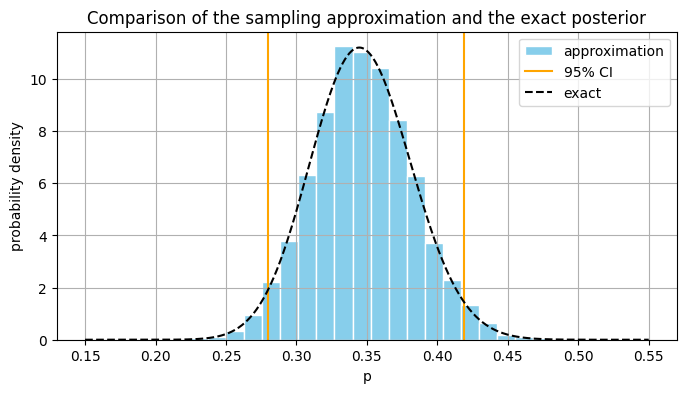
<t><center>Figure 6. Comparison of the sampling approximation and the exact posterior.</center></t>


In figure 6, we have superimposed the posterior distribution that was obtained from sampling approximation and the posterior distribution that we have calculated analytically. We also obtained the mean values from these distributions: 

<t><center>Analytical mean = 0.343</center></t>
<t><center>Sample mean = 0.345</center></t>
We can see that there is very minimal difference between the plots and expected values. Thus, this comparison further reinforces our belief that sampling has worked well. It has to be mentioned that often, we cannot use the second approach, but it was a nice touch that we could calculate and see the analytical posterior. 

## Problem 2. Create a prior

We want to model purchasing behavior at an e-commerce company. For each customer, we model the average amount of money they spend per month. Set up an appropriate model (likelihood and prior) such that the median of the average amount of money spent per customer per month is JPY 10,000 (ten thousand Japanese yen) and that 80% of customers have an average spend between JPY 1,000 and JPY 30,000.

* Motivate our choices for the prior distribution and likelihood function.
* Show that samples from the prior-predictive distribution have the percentiles indicated above. (This can be approximate but you have to quantify how close you are to the desired values.)

### Reasoning for Prior
Given the information above and some common sense we can infer several things. Firstly, the domain of the target prior distribution should not contain negative values. The reasoning behind this is that one cannot spend negative amount of money. Secondly, from simple supply-demand and the way wealth is distributed in Japan, we know that the quantity demanded decreases as the items get more expensive. This would mean that the average monthly expenditure would be assymetric and left-skewed. Finally, we know that the median of the average amount of money spent per costumer per month is JPY 10000 and that $80\%$ of costumers have an average monthly spend between JPY $[1000,30000]$. 

#### Likelihood 
<t><center>$x_i \sim TruncatedNormal(µ,\sigma^2,\alpha,\beta)$</center></t>
With the assumptions above and information provided in the prompt it can be argued that the likelihood function which describes the average monthly consumer spending can follow truncated normal distribution. Truncated normal distribution is quite convenient since we can define upper and lower bounds accordingly following the support: $x\in[0,150000]$. This is convenient for two reasons. First, the resulting distribution will not include negative values, since one cannot spend $-x$ amount of money and secondly, since it is an e-commerce company we make an assumption that a given costumer can not spend above 150000 JPY per month on average. This assumption is justified by the fact that people do not tend to spend large sums of money online and they would rather spend more in-person. Thus, an arbitrary cap at 150000 JPY was created that is approximately equivalent to 1000 US. 

The likelihood function is as follows 
<t><center>$x_i \sim TruncatedNormal(µ,\sigma^2,\alpha=\frac{0-µ}{\sigma},\beta=\frac{150000-µ}{\sigma})$</center></t>
#### Prior
<t><center>$ \sigma^2 \sim Uniform (0,10)$</center></t>
<t><center>$ \mu \sim LogNormal (µ,\sigma^2)$</center></t>
We chose two prior distribution over two unknown parameters in the likelihood function: $\mu$ and $\sigma^2$. In the Truncated-normal distribution $\mu$ represents the mean while $\sigma^2$ represents variance. We chose these distributions for the priors since $\mu$ represents the average monthly spending in JPY and cannot take negative values and has a left skew. LogNormal distribution satisfies all of these requirements. The prior distribution over sigma parameter was more of an arbitrary choice since sigma can take many different values and will only impact the spread of the distribution. Thus, unifrom distribution was chosen to assign same probability for all values between 0 and 10. 

#### Optimizing Hyperparameters 

To optimize the prior hyperparameters within LogNormal distribution several equations were employed. 
Firstly we used median = 10000 to find $\mu:$
<t><center>$ median = exp(\mu) $</center></t>
<t><center>$ \mu = \log(median) $</center></t>
<t><center>$ \mu = \log(10000) $</center></t>
<t><center>$ \mu \approx 9.21 $</center></t>

We also calculated $\sigma^2$ using maximum likelihood formula: 
<t><center>$ Z = \frac{x-\mu}{\sigma}$</center></t>
and used $\log(median)$ and $90\%$th percentile upper bound which is 30000 JPY: 
<t><center>$ \sigma = \frac{x-\mu}{Z}$</center></t>
<t><center>$ \sigma = \frac{30000-\log(10000)}{1.28}$</center></t>
Finally, we will take $\frac{30000-\log(10000)}{1.28}$ and square it to obtain $\sigma^2.$
The calculations are shown below. 


In [11]:
# Known Variables
from scipy.stats import norm
median = 10000
lower_bound = 1000
upper_bound = 30000
Z = norm.ppf(0.9)

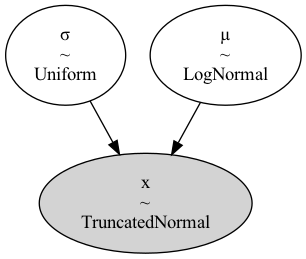

In [18]:
# Defining the model
with pm.Model() as eccomerce_model:
    # Prior
    σ = pm.Uniform('σ',0,1)
    µ = pm.Lognormal('µ', 
                           # Find mu  
                           mu = np.log(median), 
                           # Find sigma using formula σ = (x-µ)/z. x = 30000 (upper bound)
                           sigma = (np.log(upper_bound) - np.log(median)) / norm.ppf(0.9))**2 
    
    # Truncated Normal likelihood
    pm.TruncatedNormal('x', mu=µ, sigma=np.sqrt(σ), lower = (0-10000)/σ, 
                       upper = (150000-10000)/σ, observed = 1) # Set observed to an arbitrary value

from IPython.display import Image
Image(pm.model_to_graphviz(eccomerce_model).render(format='png'))

In [13]:
from scipy.stats import norm
# Model setup
with pm.Model() as ecommerce_model:
    σ = pm.Uniform('σ',0,10)
    µ = pm.Lognormal('µ', 
                           mu = np.log(median), 
                           # Using formula σ = (x-µ)/z
                           sigma = (np.log(upper_bound) - np.log(median)) / norm.ppf(0.9))**2 
    
    # Truncated Normal 
    pm.TruncatedNormal('x', mu=µ, sigma=np.sqrt(σ), observed=10, lower = (0-10000)/σ, 
                       upper = (150000-10000)/σ)
    # Prior-predictive
    prior_predictive = pm.sample_prior_predictive(samples=10000)
prior_predictive # Check what happened

Sampling: [x, µ, σ]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [14]:
# Extract and analyze the samples from the prior predictive distribution
monthly_average_spending = prior_predictive.prior['µ'].values.flatten()
# 
monthly_median = np.median(monthly_average_spending)
# Find between which values is the 80% of the average spend distributed 
quantiles = np.quantile(monthly_average_spending, [0.1, 0.9])

# Display 
error_lower = quantiles[0]-lower_bound
error_upper = quantiles[1]-upper_bound
print(f'80% of average spending is distributed between {round(quantiles[0],1)}','and',f'{round(quantiles[1],1)}','JPY')
print(f'Errors: the error around the lower bound is = {round(error_lower,2)} JPY','and ',f'error around upper bound is = {round(error_upper,2)}','JPY')

80% of average spending is distributed between 3282.5 and 30438.3 JPY
Errors: the error around the lower bound is = 2282.47 JPY and  error around upper bound is = 438.32 JPY


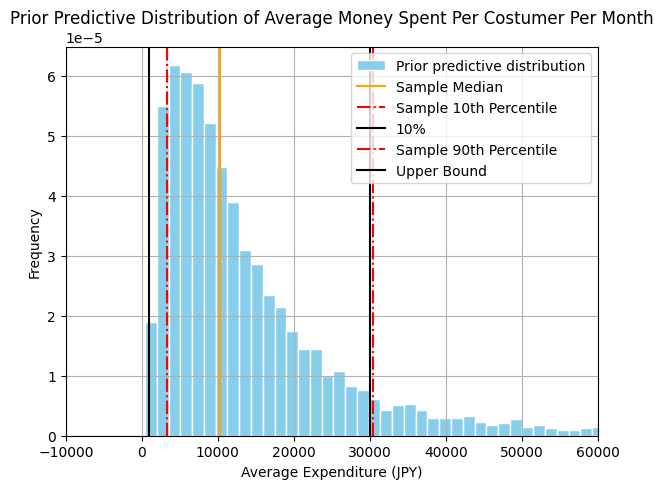

In [15]:
# Plot the histogram of the sampled prior predictive distribution
plt.figure(figsize=(6, 5))
plt.hist(monthly_average_spending, bins = 142, density=True, color = 'skyblue', edgecolor = 'white', 
         label = 'Prior predictive distribution')
plt.axvline(monthly_median, color = 'orange', linestyle = 'solid', label = 'Sample Median')
plt.axvline(quantiles[0], color = 'red', linestyle = 'dashdot', label = 'Sample 10th Percentile')
plt.axvline(lower_bound, color = 'black', linestyle = 'solid', label = '10%')
plt.axvline(quantiles[1], color = 'red', linestyle = 'dashdot', label = 'Sample 90th Percentile')
plt.axvline(upper_bound, color = 'black', linestyle = 'solid', label = 'Upper Bound')
plt.legend()
plt.title('Prior Predictive Distribution of Average Money Spent Per Costumer Per Month')
plt.xlabel('Average Expenditure (JPY)')
plt.ylabel('Frequency')
plt.grid(linestyle = 'solid')
plt.tight_layout()
plt.xlim(-10000, 60000)
plt.show()

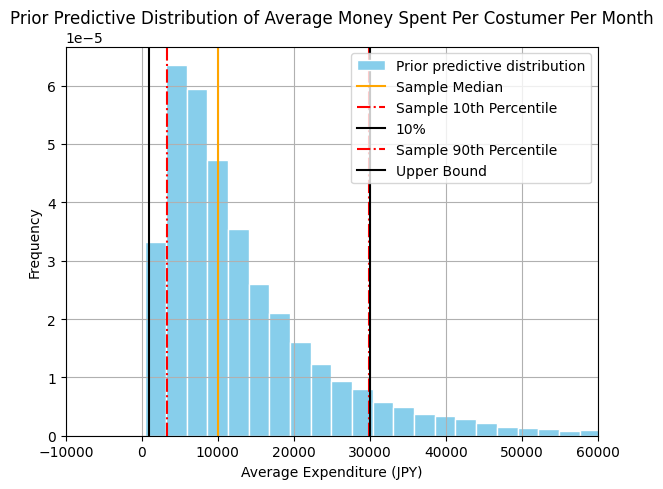
<t><center> Figure 7. Prior predictive distribution, median, sample and observed bounds. </center></t>

As we can see from the prior predictive distribution it is clear that the samples from my prior predictive distribution have the percentiles indicated above. 80% of average monthly spending is distributed between 3292.2 JPY and 29861.2 JPY. The error around the lower bound is = 2292.23 JPY and  error around upper bound is = 138.79 JPY which is very close to the percentiles indicated above. Moreover the median is exactly at the 10000 JPY which is also another indicator that prior and likelihood distributions worked and that sampling was conducted successfully. Moreover, the resulting distribution predicts that as the expenditure increases the frequency decreases which is how we generally expect consumers to behave -- again, quantity demanded decreases as the price increases. This is very common economic assumption and it is good to see that our model successfully follows it. Additionally, we can also see that there are no negative values in the distribution which shows that the combination of selecting Truncated Normal and LogNormal distributions for likelihood and prior has worked successfully and resulting distribution does not include negative values. One downside that we can observe is high error around lower bound [2292.23 JPY]. This can be attributed to how we estimated our $\sigma^2$ value. 
<t><center>$ \sigma = \frac{30000-\log(10000)}{1.28}$</center></t>
We had two bounds between which $80%$ of data was spread between. These bounds were [1000,30000] respectfully. Since we chose upper bound as an observation we have sacrificed accuracy around the lower bound. This can be improved by either changing the prior distributions or using other optimization techniques. However, for the scope of prior predictive distribution I believe that this error can be negligible.  

#### Summary Video 
The video of the summary is accessible through this google drive link which is shared with Prof. Volkan and both TAs. Link: https://drive.google.com/file/d/13L0N_uBMzVslwOfd-5HbCAbFkX4SClz5/view?usp=sharing. Additional note: it was impossible to compress video further than 300 mbs and keep it intelligible. This is why I have indicated drive link. The video is 87 seconds long so definetely below 1.5 minutes. 

#### AI Statement
I did not use Chat GPT or AI other tool for this assignment. 
I used Grammarly to check for spelling and grammar mistakes.
I obtained all the relevant formulas from the textook or from Wikipedia. 

#### References

Bernardo, J.M. and Smith, A.F.M. (1994). Bayesian Theory, Section 5.2.

McElreath, R. (2020). Statistical Rethinking, Second Edition. Chapman and Hall/CRC Press.

Minerva University. (2024). CS146: Computational Methods for Bayesian Statistics. Sessions 1-6. 

University of Carlos III Madrid. (2024). Conjugate families of distributions. Department of Statistics. Link:   https://halweb.uc3m.es/esp/personal/personas/mwiper/docencia/English/PhD_Bayesian_Statistics/ch3_2009.pdf

Wikipedia. (2024). Conjugate Prior https://en.wikipedia.org/wiki/Conjugate_prior

Wikipedia. (2024). Log Normal Distribution. https://en.wikipedia.org/wiki/Log-normal_distribution

Wikipedia. (2024). Truncated Normal Distribution. https://en.wikipedia.org/wiki/Truncated_normal_distribution
